<a href="https://colab.research.google.com/github/Reptilefury/coursera-machine-learning/blob/main/Simple_Audio_Recognition_(Recognizing_Key_words).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models 
from IPython import display

In [11]:
#Set the seed value for experiment reproducibility 
seed = 42 
tf.random.set_seed(seed)
np.random.seed(seed)

In [16]:
dataset_path = 'data/mini_speech_commands'
url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"

data_dir = pathlib.Path(dataset_path)
#Check if the file exists and download the file
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin = url,
      extract = True,cache_dir ='.',cache_subdir='data')



182091776/182082353 [==============================] - 1s 0us/step


The dataset audio clips are stored in eight folders corresponding to each command: no, yes, down, go, left, up, right, stop 

In [20]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:',commands)

Commands: ['go' 'right' 'down' 'left' 'no' 'yes' 'up' 'stop']


Extract audio clips into a list called filenames and shuffle them:

In [24]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)

num_samples = len(filenames)

print('Number of total examples:',num_samples)
print('Number of examples per label:',len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:',filenames[0])


Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/e0315cf6_nohash_2.wav', shape=(), dtype=string)


Split the file names into training validation and test sets repsectively : 80:10:10

In [31]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print("Training set files:", len(train_files)) 
print('Validation set files:',len(val_files))
print('Testing set files:', len(test_files))

Training set files: 6400
Validation set files: 800
Testing set files: 800


In [36]:
test_file = tf.io.read_file(dataset_path+'/down/0a9f9af7_nohash_0.wav')
test_audio,_ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

Function that preprocesses the dataset's raw wav audio

In [39]:
def decode_audio(audio_binary):
  audio,_ = tf.audio.decode_wav(contents=audio_binary)#Returns the audio and sample rate 
  return tf.squeeze(audio,axis=-1)

In [49]:
def get_label(file_path):
  parts = tf.strings.split(
      input= file_path,
      sep = os.path.sep,
  )
  return parts[-2]

In [50]:
from tensorflow.python.ops.gen_audio_ops import decode_wav
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  wavform = decode_audio(audio_binary)
  return  wavform,label

AUTOTUNE = tf.data.AUTOTUNE

file_ds = tf.data.Dataset.from_tensor_slices(train_files)


waveform_ds = file_ds.map(
    map_func = get_waveform_and_label,
    num_parallel_calls=AUTOTUNE
)

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

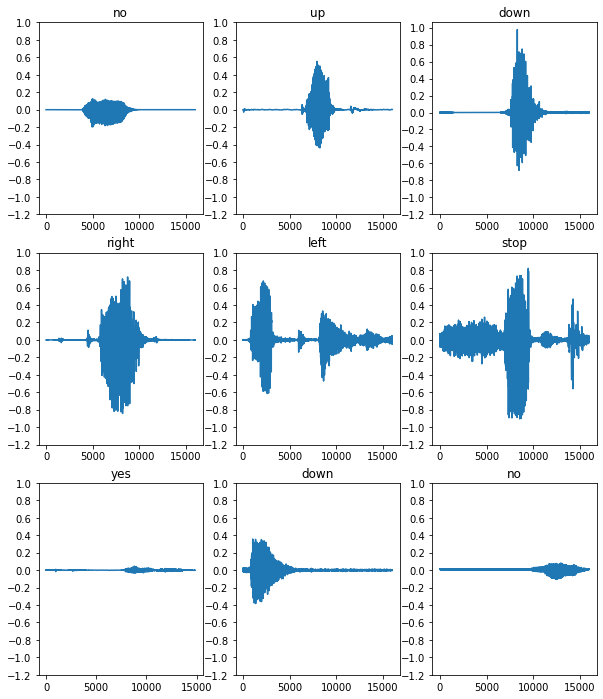

In [68]:
import matplotlib.pyplot as plt

rows = 3
cols = 3
n = rows * cols 
fig, axes = plt.subplots(rows,cols , figsize=(10,12))
for i, (audio,label) in enumerate(waveform_ds.take(n)):
  r = i //cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2,1.2,0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [82]:
def get_spectrogram(waveform):
  #Zero padding for an audio form with less than 16,000 samples 
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype = tf.float32
  )
  waveform = tf.cast(waveform, dtype=tf.float32)  
  equal_length = tf.concat([waveform, zero_padding],0)
  #Convert the waveform to a spectrogram via the short time fourier transform
  spectrogram = tf.signal.stft(equal_length,frame_length=255,frame_step = 128)
  #Get the magnitude of the stft 
  spectrogram = tf.abs(spectrogram)
  #Add a channel like dimension so that the spectrogram can be used as image like input data with convolution layers
  spectrogram = spectrogram[...,tf.newaxis]
  return spectrogram

In [86]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label',label)
print('Wave form shape:', waveform.shape)
print('spectrogram shape:',spectrogram.shape)
print('Audio playback:')
display.display(display.Audio(waveform,rate=16000))

Label no
Wave form shape: (16000,)
spectrogram shape: (124, 129, 1)
Audio playback:


Function for displaying a spectrogram

In [90]:
def plot_spectrogram(spectrogram,ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram,axis=-1)


log_spec = np.log(spectrogram.T +  np.finfo(float).eps)
height = log_spec.shape[0]
width = log_spec.shape[1]
X = np.linspace(0, np.size(spectrogram),num=width,dtype=input)
Y = range(height)
ax.pcolormesh( ) 